In [203]:
!pip install CFEDemands==0.1.6.3
!pip show CFEDemands

  Using cached https://files.pythonhosted.org/packages/e1/d9/ef36cfd235c4c299e4a036e19e9c49c4e2a62e77b0eed6048246d7ca1c49/CFEDemands-0.1.6.3-py2.py3-none-any.whl
  Found existing installation: CFEDemands 0.1.6.6
    Uninstalling CFEDemands-0.1.6.6:
      Successfully uninstalled CFEDemands-0.1.6.6
Name: CFEDemands
Version: 0.1.6.3
Summary: Tools for estimating and computing Constant Frisch Elasticity (CFE) demands.
Home-page: https://bitbucket.org/ligonresearch/cfedemands
Author: Ethan Ligon
Author-email: ligon@berkeley.edu
License: Creative Commons Attribution-Noncommercial-ShareAlike 4.0 International license
Location: /Users/chan/anaconda3/lib/python3.7/site-packages
Requires: 
Required-by: 


In [204]:
import cfe
import pandas as pd
import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

# LOAD DATA SETS

In [35]:
data_no_food_stamps = pd.read_csv('../data/actual/no_food_stamps.csv')
data_yes_food_stamps = pd.read_csv('../data/actual/yes_food_stamps.csv')

columns_to_drop = ['Unnamed: 0', 'id_2', 'supp_security']

data_no_food_stamps.drop(columns = columns_to_drop, inplace = True)
data_yes_food_stamps.drop(columns = columns_to_drop, inplace = True)

datasets = {'no_stamps': data_no_food_stamps,
           'yes_stamps': data_yes_food_stamps}

In [28]:
data_yes_food_stamps.columns

Index(['id', 'age', 'highest_education', 'profession', 'avg(GROSPAYX)',
       'hispanic', 'weekly_hours_worked', 'in_college', 'is_married',
       'schoolmeals_purchases', 'self_employed', 'sex', 'reason_unemployment',
       'main_profession', 'numweeks_schoolmeals', 'psu', 'psu_popsize',
       'net_income', 'FWAGEXM', 'alcbev', 'bakery', 'beef', 'cereal',
       'child_age', 'housing_type', 'census_division', 'eggs', 'fam_size',
       'food_away', 'food_home', 'total_food', 'fresh_fruit', 'fresh_veg',
       'value_foodstamps', 'number_foodstamps', 'non_alc_grocery', 'milk',
       'number_earners', 'non_alc_bevs', 'oils', 'othdairy', 'othmeat',
       'members_under18', 'members_over64', 'pet_food', 'pork', 'procfruit',
       'proc_veg', 'spouse_race', 'foodstamp_or_not', 'seafood', 'smoking',
       'lives_in_MSA', 'state', 'sweets', 'vehicle', 'total_food_percent'],
      dtype='object')

Note that net_income refers to annual income, whereas all other spending is in weekly dollars.

## Quick summary

In [137]:
data_no_food_stamps.dropna(subset=food_spending, inplace=True)
data_no_food_stamps[['net_income', 'age', 'total_food', 'total_food_percent', 'number_foodstamps']].describe()

,net_income,age,total_food,total_food_percent,number_foodstamps
count,4884.000000,4884.000000,4884.000000,4884.000000,0.0
mean,87416.968591,52.480344,149.098386,0.135048,NaN
std,81609.006952,17.442543,115.825383,0.126639,NaN
min,732.000000,9.000000,0.995000,0.000878,NaN
25%,33856.800000,38.000000,66.129550,0.055184,NaN
50%,62064.200000,53.000000,122.010000,0.098382,NaN
75%,110925.000000,66.000000,201.366217,0.168146,NaN
max,835530.800000,88.000000,1146.884230,0.980775,NaN


In [138]:
data_yes_food_stamps.dropna(subset=food_spending, inplace=True)
data_yes_food_stamps[['net_income', 'age', 'total_food', 'total_food_percent', 'number_foodstamps']].describe()

,net_income,age,total_food,total_food_percent,number_foodstamps
count,491.000000,491.000000,491.000000,491.000000,484.000000
mean,33749.366395,48.790224,107.321433,0.230127,10.250000
std,41663.954735,16.722305,106.677219,0.191928,3.394292
min,1191.000000,18.000000,1.745000,0.003985,1.000000
25%,13172.000000,34.000000,40.250000,0.089932,11.000000
50%,23379.000000,48.000000,75.415000,0.180132,12.000000
75%,39472.600000,61.000000,134.542503,0.304530,12.000000
max,552695.000000,88.000000,822.123510,0.977889,12.000000


## Estimating food demand 

In [184]:
sample = ['bakery', 'beef', 'eggs']


food_spending = ['bakery', 'beef', 'cereal', 'eggs',
                 'fresh_fruit', 'fresh_veg', 'milk',
                 'oils', 'othdairy', 'othmeat', 'pork',
                 'procfruit', 'proc_veg', 'seafood', 'sweets']

In [198]:
def getZ(dataset):
    z_vals = dataset[['id', 'age', 'sex', 'fam_size']]
    z_vals['M'] = ""
    z_vals['F'] = ""
    z_vals['log_famsize'] = np.log(z_vals['fam_size'])
    
    #STANDARDISE CODE TO PROF. LIGON'S FORMAT
    
    z_vals['j'] = z_vals['id']
    z_vals['t'] = 17
    z_vals['m'] = 'A'

    z_vals.loc[z_vals['sex'] == 'Male', 'M'] = 1
    z_vals.loc[z_vals['M'] == '', 'M'] = 0
    z_vals.loc[z_vals['sex'] == 'Female', 'F'] = 1
    z_vals.loc[z_vals['F'] == '', 'F'] = 0

    z_vals.drop(columns = ['sex', 'fam_size', 'id'], inplace = True)
    z_vals.set_index(['j','t','m'],inplace=True)
    
    #REORDER
    
    return z_vals

getZ(data_yes_food_stamps).head(10)

,,,age,M,F,log_famsize
j,t,m,,,,
360954,17,A,66,0,1,0.000000
360960,17,A,50,0,1,0.000000
360971,17,A,65,0,1,1.386294
361039,17,A,31,0,1,0.000000
361077,17,A,73,0,1,0.000000
361086,17,A,39,1,0,1.609438
361115,17,A,64,1,0,1.609438
361123,17,A,71,1,0,0.693147
361147,17,A,88,1,0,0.693147


In [200]:
def getX(dataset):
       
    x_vals = dataset[['bakery', 'beef', 'eggs']]
    
    #x_vals_noisy = x_vals + np.random.rand()/100.0
    
    x_vals['j'] = dataset['id']
    x_vals['t'] = 17
    x_vals['m'] = 'A'

    x_vals['bakery'] = x_vals['bakery']
    x_vals['beef'] = x_vals['beef']
    x_vals['eggs'] = x_vals['eggs']
    
    x_vals.set_index(['j','t','m'],inplace=True)
 
    return x_vals

def getY(dataset):
    x_vals = getX(dataset)
    y_vals = np.log(x_vals.replace(0,np.nan))
    return y_vals

getY(data_yes_food_stamps).head(10)

,,,bakery,beef,eggs
j,t,m,,,
360954,17,A,1.922056,NaN,-0.005013
360960,17,A,2.466403,1.015231,NaN
360971,17,A,2.095462,NaN,NaN
361039,17,A,1.690096,1.249902,NaN
361077,17,A,0.916291,NaN,NaN
361086,17,A,NaN,NaN,NaN
361115,17,A,2.443777,NaN,NaN
361123,17,A,1.554982,3.170106,0.568151
361147,17,A,1.728997,-0.180324,0.657520


In [207]:
TEST = data_yes_food_stamps

y_vals = getY(TEST)
z_vals = getZ(TEST)
    
result = cfe.Result(y=y_vals, z=z_vals)
result.get_reduced_form()
#result.delta.to_dataframe().unstack('k')
#result.a.to_dataframe().unstack('i')
#result.get_beta().to_dataframe()
    


LinAlgError: Singular matrix

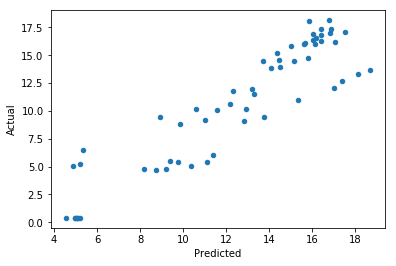

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

result_ank.get_predicted_log_expenditures()

x_ank = result_ank.y.sum('i').to_dataframe().squeeze()
xhat_ank = result_ank.yhat.sum('i').to_dataframe().squeeze()

# Make dataframe of actual & predicted
df_ank = pd.DataFrame({'Actual':x_ank,'Predicted':xhat_ank})

df_ank.plot.scatter(x='Predicted',y='Actual')

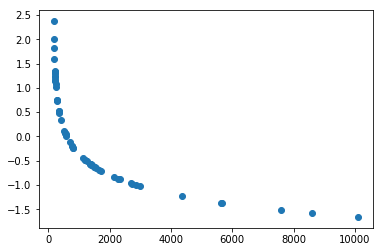

In [13]:
%matplotlib inline
import cfe
import pandas as pd
import pylab as pl

r0 = result_ank

# Turn off variation in household composition
r0['z'] = r0['z']*0

# select years and markets you want
l0 = r0.loglambdas.sel(t=17,m='A')

# Predicted total expenditures given lambda & prices
x0 = r0.get_predicted_expenditures().sum('i').sel(t=17,m='A')

pl.scatter(x0,l0)
pl.show()